# Trabajo Práctico N°1: FIUFIP
---
El siguiente informe es parte del trabajo grupal realizado para la materia de **Organización de Datos (75.06/95.58)** dictada en la **Facultad de Ingeniería de la Universidad 
de Buenos Aires (FIUBA)** durante el primer cuatrimestre del 2021.



Integrantes - Grupo 2:

Nombre | Padrón | Email
------ | ------| -------------
[BIANCARDI, Julian](https://github.com/JulianBiancardi) | 103945 | jbiancardi@fi.uba.ar
[HETREA, Joaquín Emanuel](https://github.com/JoaquinHetrea) | 103944 | jhetrea@fi.uba.a

---

# Enunciado

**Introducción:**

Una agencia gubernamental de recaudación de impuestos la FIUFIP nos a pedido que atrapemos a malechores que evaden impuestos y destruyen la economía.

Para ello la agencia desea entender la información que han estado recolectando de gente que paga los impuestos y quiere tener un sistema para el cual saber si una persona tiene altos ingresos o bajos ingresos a partir de los mismos.

Estos datos consisten en una serie de atributos de la persona que la agencia fue llenando y catalogando a la persona como de altos ingresos o no.

La agencia quiere utilizar la información recolectada para dirigir campañas de recaudación de impuestos y poder dirigir a los fiuagentes recaudadores a inspeccionar.

**Tarea:**

La primer tarea que nos piden es que presentemos un informe explicando qué conclusiones se pueden llegar a partir de analizar los datos recolectados. La agencia quiere saber cómo entender cada uno de los datos, cómo se relacionan entre sí y si se puede sacar alguna conclusión o descubrir un patrón a partir de estos. Adicionalmente quieren saber cuáles son los factores más importantes que determinan si un usuario tiene altos o bajos ingresos.

Si bien la agencia quiere empezar a usar técnicas avanzadas de predicción e inteligencia artificial, todavía tiene desconfianza en las mismas (personalmente comentaron que tienen miedo que las máquinas se revelen contra ellos) por lo que inicialmente no quieren nada complicado sino una serie muy simple de decisiones lógicas que les permitan en poco tiempo hacer una primera ronda de campaña digital. Se espera que este código simple (baseline) tenga una accuracy aceptable (mayor a 80%) y que esté basada y justificada en la investigación previa.

# Limpieza de datos

In [148]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt
import seaborn as sns

from collections import Counter
import requests

In [149]:
with requests.get(
    "https://docs.google.com/spreadsheets/d/1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0/export?format=csv"
) as r, open("impuestos.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)

Primero vemos el dataframe que se nos provee con la función **read_csv** : 

In [150]:
df = pd.read_csv("impuestos.csv")
df.head()

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
0,17,Palermo,empleado_provincial,39,universidad_3_anio,sin_matrimonio,2174,hombre,40,cristianismo,sin_familia,0,entretenimiento
1,17,Palermo,monotibutista,50,universidad_3_anio,matrimonio_civil,0,hombre,13,cristianismo,casado,0,directivo_gerente
2,13,Palermo,relacion_de_dependencia,38,4_anio,divorciado,0,hombre,40,cristianismo,sin_familia,0,limpiador
3,11,Palermo,relacion_de_dependencia,53,2_anio,matrimonio_civil,0,hombre,40,judaismo,casado,0,limpiador
4,17,Balvanera,relacion_de_dependencia,28,universidad_3_anio,matrimonio_civil,0,mujer,40,judaismo,casada,0,profesional_especializado


Vemos que con el comando **info()** tenemos la informacion completa del dataframe. Algunos features como por ejemplo: barrio, trabajo, etc tiene como tipo de dato *object* (default por el programa), por lo que deberemos cambiar estos tipos de datos.

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   anios_estudiados                            32561 non-null  int64 
 1   barrio                                      31978 non-null  object
 2   categoria_de_trabajo                        30725 non-null  object
 3   edad                                        32561 non-null  int64 
 4   educacion_alcanzada                         32561 non-null  object
 5   estado_marital                              32561 non-null  object
 6   ganancia_perdida_declarada_bolsa_argentina  32561 non-null  int64 
 7   genero                                      32561 non-null  object
 8   horas_trabajo_registradas                   32561 non-null  int64 
 9   religion                                    32561 non-null  object
 10  rol_familiar_registrad

In [152]:
(df.isnull().mean() * 100).to_frame('porcentaje nulls')

,porcentaje nulls
anios_estudiados,0.000000
barrio,1.790486
categoria_de_trabajo,5.638647
edad,0.000000
educacion_alcanzada,0.000000
estado_marital,0.000000
ganancia_perdida_declarada_bolsa_argentina,0.000000
genero,0.000000
horas_trabajo_registradas,0.000000
religion,0.000000


---
> Para este trabajo optamos por no eliminar las filas duplicadas ya que consideramos que seria informacion relevante para nuesto analisis exploratorio. Esto se debe a que no contenemos ninguna informacion que identifique una entrada de otra. Entonces el comando **drop_duplicates()** seria innecesario.
---



Por otro lado, analizaremos si los features numericos contienen valores invalidos. Para la *edad* nunca puede ser negativo y supusimos que aquellos mayores a 17 son considerados validos. Asi con las demas columnas. El caso particular de *ganancia_perdida_declarada_bolsa_argentina* se admite numero negativo representado perdida. Vemos asi que todos las columnas cuentan con información valida.

In [153]:
df.describe()

,anios_estudiados,edad,ganancia_perdida_declarada_bolsa_argentina,horas_trabajo_registradas,tiene_alto_valor_adquisitivo
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,14.053868,38.581647,990.345014,40.437456,0.240810
std,2.664488,13.640433,7408.986951,12.347429,0.427581
min,1.000000,17.000000,-4356.000000,1.000000,0.000000
25%,13.000000,28.000000,0.000000,40.000000,0.000000
50%,14.000000,37.000000,0.000000,40.000000,0.000000
75%,16.000000,48.000000,0.000000,45.000000,0.000000
max,20.000000,90.000000,99999.000000,99.000000,1.000000


La columna *barrio* contiene algunos barrios en mayuscula y otros en minuscula, por lo que por comodida pasaremos todo a un mismo formato. Por otro lado algunas filas no cuentan con informacion, decidimos agregar una nueva categoria llamada *otro*.

In [154]:
df['barrio'] = df['barrio'].str.lower()
df['barrio'].replace({None: "otro"}, inplace=True)

**PONER ACA LO DE TRABAJO Y CATEGORIA NULL QUE LO PUSIMOS COMO UNA CATEGORIA MAS**

La columna *rol_familiar_registrado* cuenta con las categorias casado y casada por separado. Entonces decidimos juntarlas para asi tener menos categorias dentro de la misma.

In [155]:
df['rol_familiar_registrado'].replace({"casado": "casado_a", "casada": "casado_a"}, inplace=True)

Algunas columnas como por ejemeplo *categoria_de_trabajo* contienen algunos valores mal escritos. Procederemos a arreglarlos:

In [156]:
df['categoria_de_trabajo'].replace({"monotibutista": "monotributista"}, inplace=True)

La columna *tiene_alto_valor_adquisitivo* es de tipo int64 cuando solo toma los valores 0 o 1, por lo que la cambiaremos a *bool* que consideramos mas acorde.

In [157]:
df['tiene_alto_valor_adquisitivo'] = df['tiene_alto_valor_adquisitivo'].astype(np.bool)

Vemos de las columnas con tipo *object* cuales son las que tienen un valor unico. En nuestro caso ninguna de ellas, por lo que todas las columnas seran de tipo *category*.

In [158]:
df.select_dtypes(include=['object']).nunique()

barrio                     42
categoria_de_trabajo        8
educacion_alcanzada        16
estado_marital              7
genero                      2
religion                    5
rol_familiar_registrado     5
trabajo                    14
dtype: int64

In [159]:
df['barrio'] = df['barrio'].astype("category")
df['categoria_de_trabajo'] = df['categoria_de_trabajo'].astype("category")
df['educacion_alcanzada'] = df['educacion_alcanzada'].astype("category")
df['estado_marital'] = df['estado_marital'].astype("category")
df['genero'] = df['genero'].astype("category")
df['religion'] = df['religion'].astype("category")
df['rol_familiar_registrado'] = df['rol_familiar_registrado'].astype("category")
df['trabajo'] = df['trabajo'].astype("category")

El dataframe nos queda entonces de la siguiente manera.

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   anios_estudiados                            32561 non-null  int64   
 1   barrio                                      32561 non-null  category
 2   categoria_de_trabajo                        30725 non-null  category
 3   edad                                        32561 non-null  int64   
 4   educacion_alcanzada                         32561 non-null  category
 5   estado_marital                              32561 non-null  category
 6   ganancia_perdida_declarada_bolsa_argentina  32561 non-null  int64   
 7   genero                                      32561 non-null  category
 8   horas_trabajo_registradas                   32561 non-null  int64   
 9   religion                                    32561 non-null  category
 10

# Analisis de datos

Para el analisis de los datos provistos decidimos realizar los siguientes pasos:


1.   Graficar las distribuciones de las distintas columnas para visualizar asi con que estamos trabajando,
2.   Relacionar cada columna con la varibale objetivo para obtener conclusiones,
3.   En base a las conclusiones obtenidas en el punto anterior, elejir aquella columna que mejor estime la variable objetivo,
4.   Repetir el paso 3 hasta que la subdivisión ya no sea considerable

## Distribuciones de los datos

Arrancaremos graficando las distintas distribuciones de todas las columnas para ver con que datos nos encontramos.

Text(0.5, 0, 'Horas de Trabajo')

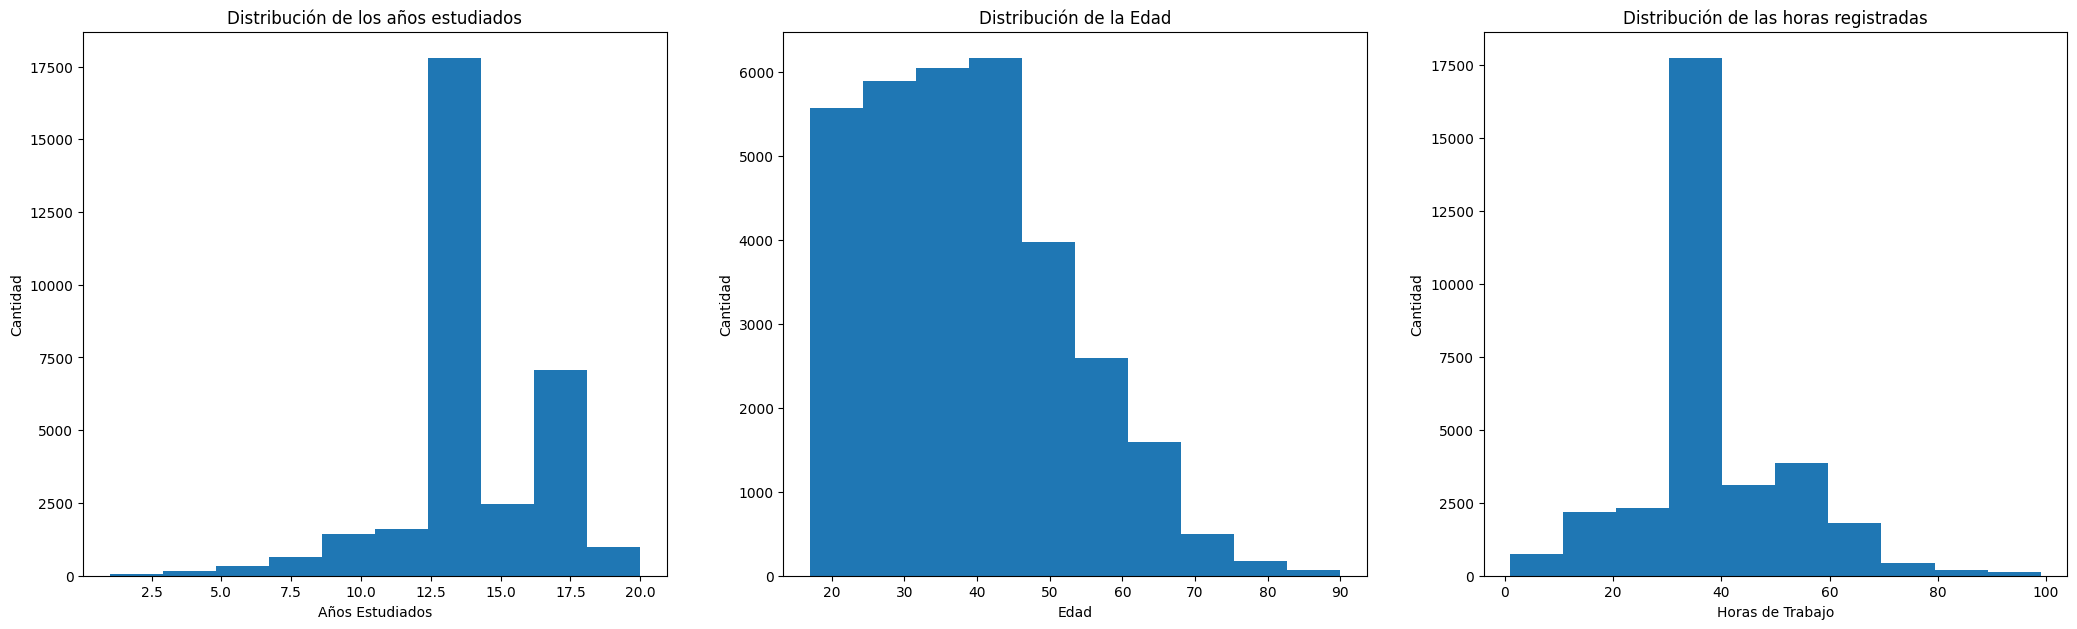

In [161]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=[6.4 * 4, 4.8 * 1.5], dpi=100)

df.anios_estudiados.plot(kind='hist', ax=axes[0])
axes[0].set_title("Distribución de los años estudiados")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Años Estudiados")

df.edad.plot(kind='hist', ax=axes[1])
axes[1].set_title("Distribución de la Edad")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Edad")

df.horas_trabajo_registradas.plot(kind='hist', ax=axes[2])
axes[2].set_title("Distribución de las horas registradas")
axes[2].set_ylabel("Cantidad")
axes[2].set_xlabel("Horas de Trabajo")


Text(0, 0.5, 'Barrio')

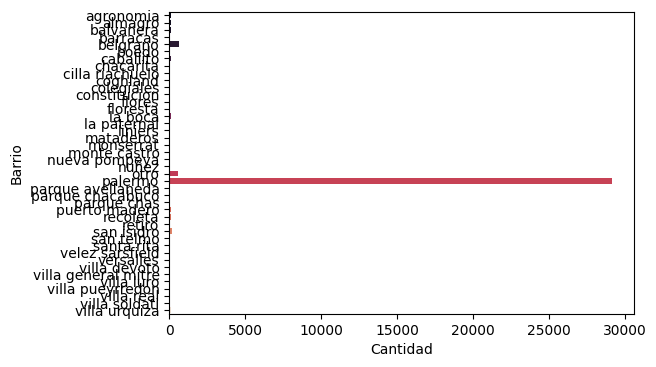

In [162]:
plt.figure(dpi=100)
ax = sns.countplot(y='barrio',data=df,palette='rocket')
ax.set_xlabel("Cantidad")
ax.set_ylabel("Barrio")

Text(0, 0.5, 'Cantidad')

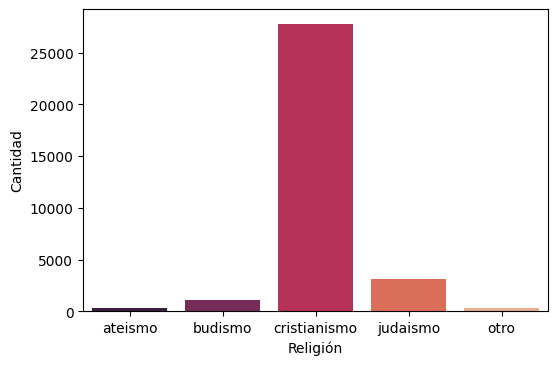

In [163]:
plt.figure(dpi=100)
ax = sns.countplot(x='religion',data=df,palette='rocket')
ax.set_xlabel("Religión")
ax.set_ylabel("Cantidad")

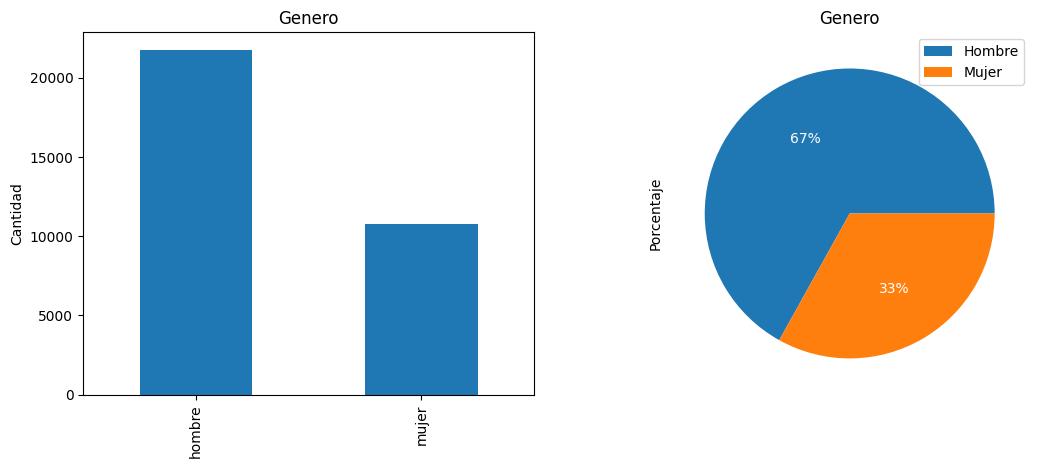

<Figure size 480x320 with 0 Axes>

In [164]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df.genero.value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title("Genero")
axes[0].set_ylabel("Cantidad")

plt.figure(dpi=80)
df["genero"].value_counts().plot(
    kind='pie', autopct='%1.0f%%', textprops={'color':"w"},ax=axes[1]
)
axes[1].legend(labels=['Hombre','Mujer'])
axes[1].set_title("Genero")
axes[1].set_ylabel("Porcentaje")

plt.show()

(-10000.0, 10000.0)

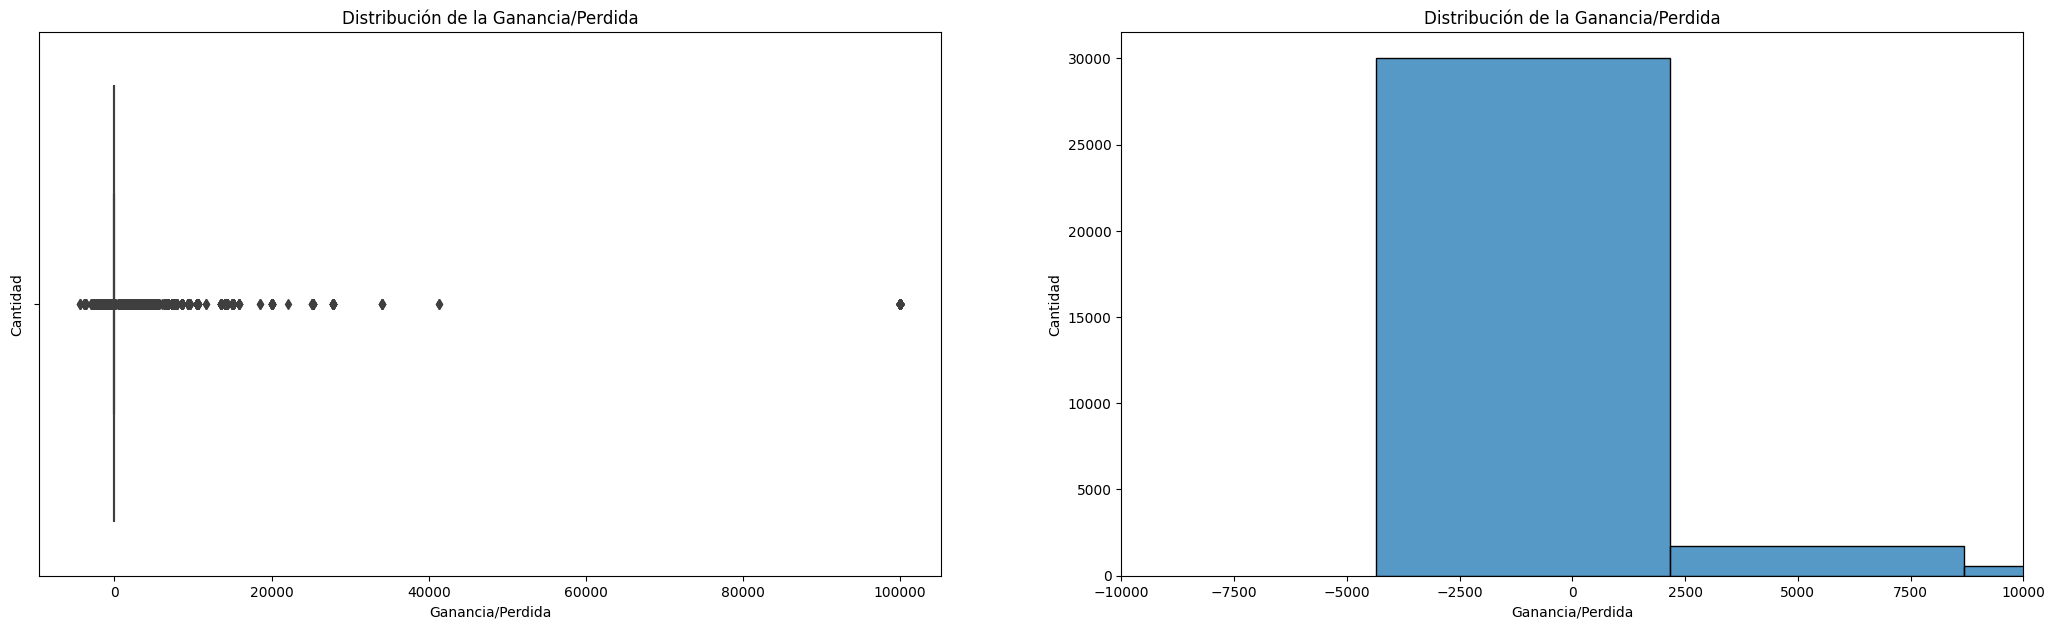

In [165]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 4, 4.8 * 1.5], dpi=100)

sns.boxplot(x='ganancia_perdida_declarada_bolsa_argentina',data=df, ax=axes[0])
axes[0].set_title("Distribución de la Ganancia/Perdida")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Ganancia/Perdida")

sns.histplot(x='ganancia_perdida_declarada_bolsa_argentina',data=df, ax=axes[1])
axes[1].set_title("Distribución de la Ganancia/Perdida")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Ganancia/Perdida")
plt.xlim([-10000,10000])



De los graficos anteriores podemos identificar que la mayor parte de la gente entrevistada es hombre, sigue al cristianismo, son de Palermo, en un rango de edad entre 20 y 50 años, con una cantidad de entre 10 a 15 años estudiados y con balance neutro declarada en la bolsa argentina.

Por otro lado, nos dimos cuenta que tanto la columna *anios_estudiados* y *educacion_alcanzada* se relacionaban linealmente. Decidimos eliminar la columna *educacion_alcanzada*.

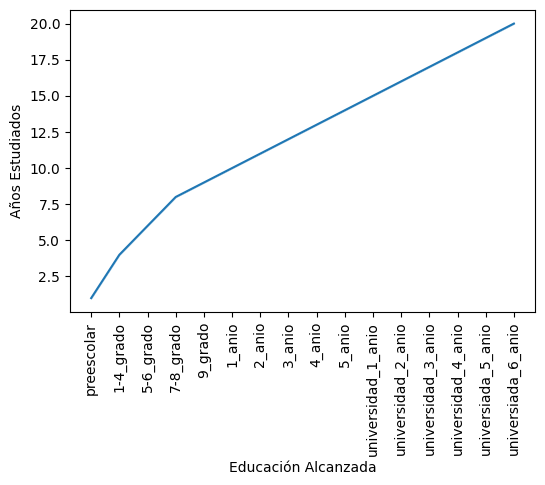

In [166]:
df['educacion_alcanzada'] = pd.Categorical(df['educacion_alcanzada'], categories=[
    'preescolar', '1-4_grado', '5-6_grado',
    '7-8_grado', '9_grado', '1_anio',
    '2_anio', '3_anio', '4_anio',
    '5_anio', 'universidad_1_anio',
    'universidad_2_anio', 'universidad_3_anio',
    'universidad_4_anio', 'universiada_5_anio',
    'universiada_6_anio'
], ordered=True)

plt.figure(dpi=100)
ax = sns.lineplot(
    data=df, 
    x='educacion_alcanzada',
    y='anios_estudiados',
    sort = True,
)
ax.set_ylabel("Años Estudiados")
ax.set_xlabel("Educación Alcanzada")
plt.xticks(rotation=90)
plt.show()

In [167]:
del(df['educacion_alcanzada'])

Veamos si hay alguna correlación lineal entre las columnas numericas:

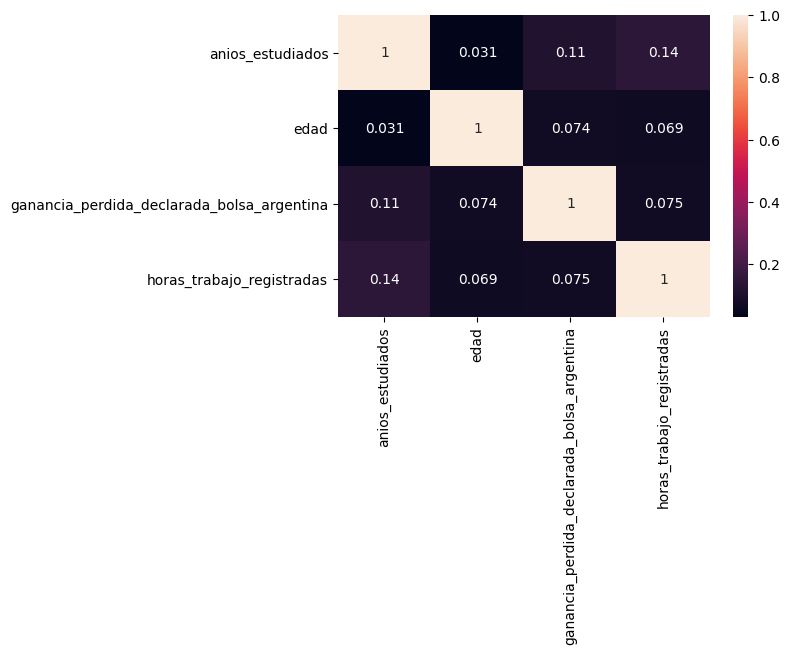

In [168]:
df_correlation = df.drop(columns=['tiene_alto_valor_adquisitivo'])
plt.figure(dpi=100)
sns.heatmap(df_correlation.corr(), annot=True)
plt.show()

Por ultimo realizaremos un grafico que nos muestre la proporción de aquellas personas que tienen alto valor adquisitivo:

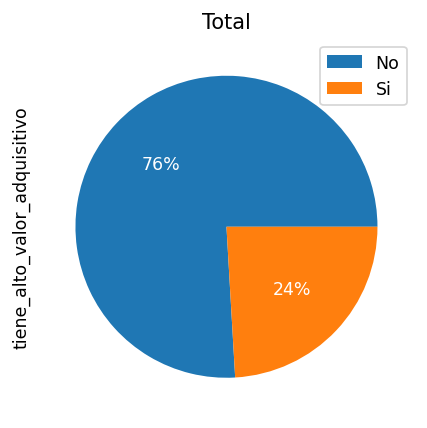

In [169]:
plt.figure(dpi=125)
df["tiene_alto_valor_adquisitivo"].value_counts().plot(
    kind='pie', autopct='%1.0f%%', textprops={'color':"w"}
)
plt.legend(labels=['No','Si'])
plt.title("Total")
plt.show() 

Vemos que la mayoria de las personas entrevistadas no tienen alto valor adquisitivo. Nos basaremos en esta relacion para los siguientes analisis, para asi determinar si la información aporta o no a llegar a una conclusión.

Entonces, conociendo las proporciones para saber si una persona tendrá alto valor adquisitivo, nos iremos preguntando si cada columna tiene una relación fuerte con la variable objetivo.

## ¿El genero de la persona nos podrá decir algo acerca si la persona tiene o no alto valor adquisitivo?

Si separamos por genero vemos que las mujeres son mas propensas a no tener alto valor adquisitivo. En el caso de los hombres la division es equitativa por lo que no podemos generar una afirmación certera.

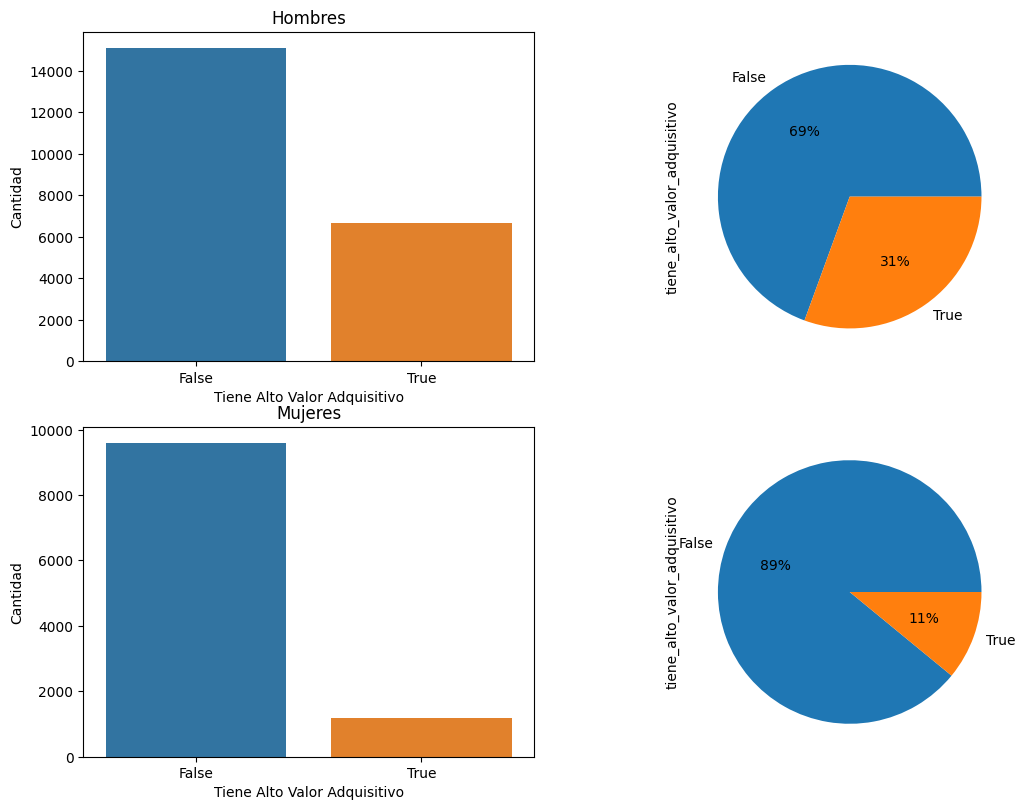

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

In [170]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[6.4 * 2, 4.8* 2], dpi=100)

df_men = df[df['genero'] == 'hombre']
df_women = df[df['genero'] == 'mujer']

sns.countplot(x='tiene_alto_valor_adquisitivo',data=df_men,ax=axes[0][0])
axes[0][0].set_title("Hombres")
axes[0][0].set_ylabel("Cantidad")
axes[0][0].set_xlabel("Tiene Alto Valor Adquisitivo")

plt.figure(dpi=100)
df_men["tiene_alto_valor_adquisitivo"].value_counts().plot(
    kind='pie', autopct='%1.0f%%',ax=axes[0][1]
)

sns.countplot(x='tiene_alto_valor_adquisitivo',data=df_women,ax=axes[1][0])
axes[1][0].set_title("Mujeres")
axes[1][0].set_ylabel("Cantidad")
axes[1][0].set_xlabel("Tiene Alto Valor Adquisitivo")

plt.figure(dpi=100)
df_women["tiene_alto_valor_adquisitivo"].value_counts().plot(
    kind='pie', autopct='%1.0f%%',ax=axes[1][1]
)

plt.show()

Por lo que llegamos a nuestra primera conclusión: 
 - **Si la persona es mujer, estamos un 89% seguros que NO tendrá valor adquisitivo.**

Pasemos ahora a nuestra segunda pregunta

## ¿La ganancia/perdida en la bolsa argentina influye al valor adquisitivo?

Para hacer este analisis primero vamos a separar los valores posibles en tres categorias: 
1.   Negativo: aquellos que tienen perdidas declaradas
2.   Positivo: aquellos que tienen ganancias declaradas
3.   Muy Positivo: aquellos que tienen ganancias por encima de un valor a determinar
4.   Neutro: aquellos que no declaran ni ganancia ni perdida


In [171]:
def balance(bolsa):
    if ((bolsa > 0) & (bolsa < 7000)):
        return "Positivo"
    elif bolsa < 0:
        return "Negativo"
    elif bolsa > 7000:
        return "Muy Positivo"
    else:
        return "Neutro"

df['balance'] = df["ganancia_perdida_declarada_bolsa_argentina"].apply(balance)

Una vez separado estos rangos de valores, veamos si alguno de estos tiene relación con el valor adquisitivo:

Text(0, 0.5, 'Cantidad')

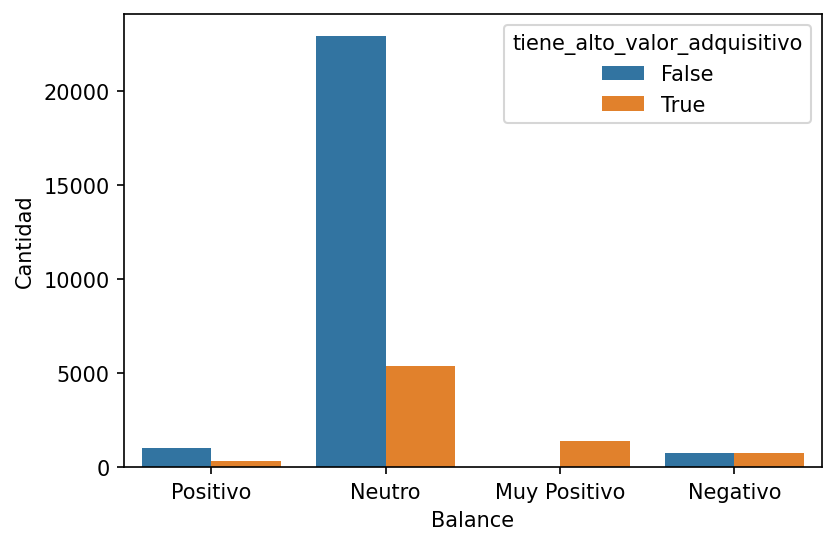

In [172]:
plt.figure(dpi=150)
ax = sns.countplot(x='balance',data=df,hue='tiene_alto_valor_adquisitivo')
ax.set_xlabel("Balance")
ax.set_ylabel("Cantidad")

En el siguiente grafico vemos que aquellos con balance neutro son mas propensos a no tener alto valor adquisitivo. Aquellos que tienen un balance muy positivo tienden a tener alto valor adquisitivo. Para los otros dos casos no nos dice mucho.

Por lo que llegamos asi a nuestra segunda conclusión: 
 - **Si la persona tiene balance neutro, estamos un 81% seguros que NO tendrá valor adquisitivo**

 (No es tan fuerte como la anterior pero consideramos que es relevante)

## ¿Que relación tienen los años estudiados con el valor adquistivo?

Veamos cual es la proporcion de personas con valor adquistivo y las que no con respecto a los años estudiados por la misma:

Text(0.5, 0, 'Años Estudiados')

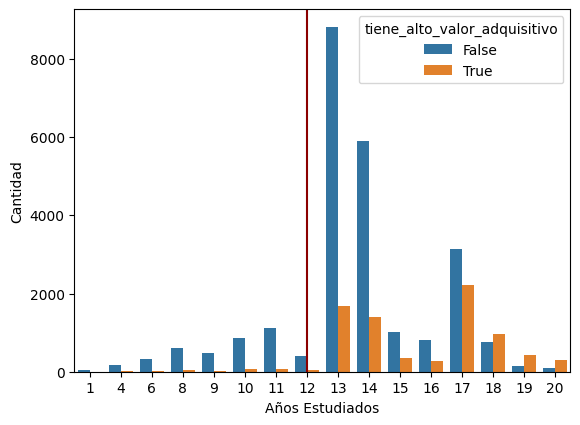

In [173]:
plt.figure(figsize=(6.4, 4.8),dpi=100)
ax = sns.countplot(x='anios_estudiados',data=df,hue='tiene_alto_valor_adquisitivo')
plt.axvline(x=7, color="darkred")
ax.set_ylabel("Cantidad")
ax.set_xlabel("Años Estudiados")

Del siguiente grafico diferenciamos dos zonas escenciales. Por un lado aquellas que tienen menos de 12 años estudiados son menos propenso a tener valor adquisitivo. Esto ultimo se ve claramente debido a que por cada cantidad de año estudiado las proporciones de no tener valor adquisitivo son mayores considerablemente. Por otro lado a medida que aumenta la cantidad de años estudiados tambien lo hace la proporcion de personas con valor adquisitivo.

Veamos cuanta es la cantidad de gente que tiene menos de 12 años estudiados:

In [174]:
total = len(df)
cantidad = len(df[df['anios_estudiados'] <= 12])
porcentaje = (cantidad / total) * 100
print("Unas ",cantidad, " personas estudiaron menos de 12 años inclusive. Aproximadamente un ",porcentaje,"% del total.")

Unas  4253  personas estudiaron menos de 12 años inclusive. Aproximadamente un  13.061638156076288 % del total.


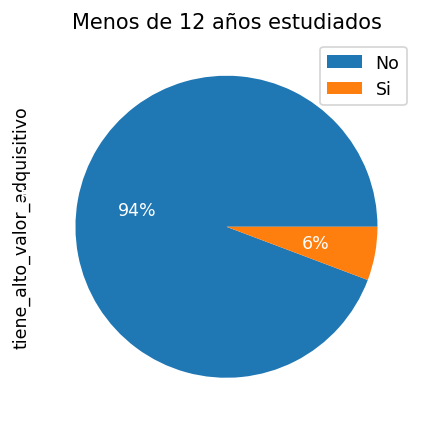

In [175]:
plt.figure(dpi=125)
df_menos_12 = df[df['anios_estudiados'] <= 12]
df_menos_12["tiene_alto_valor_adquisitivo"].value_counts().plot(
    kind='pie', autopct='%1.0f%%', textprops={'color':"w"}
)
plt.legend(labels=['No','Si'])
plt.title("Menos de 12 años estudiados")
plt.show() 

A pesar de que las proporciones son muy favorables a decir que no tiene valor adquistivo hay que tener en cuenta que esta información es acerca del 13% del total del gente entrevistada. Por lo que la siguiente conclusión resulta ser debil con respecto a las anteriores:

 - **Si la persona estudio menos que 12 años inclusive, estamos un 94% seguros que NO tendrá valor adquisitivo.**

## ¿Que relación tienen la religión de la persona con el valor adquistivo?

Hagamos unos calculos rapidos para determinar si la religión influye o no. Calculamos para cada religión el porcentaje de personas con valor adquistivo y sin valor adquisitivo. Adicionalmente vemos que proporción del total representa dicha religión para saber si la información resulta ser relevante para el analisis.

In [176]:
def si(x):
    return (x == True).mean() * 100.0
def no(x):
    return (x == False).mean() * 100.0
def perc_total(x):
    return (x.count() / len(df)) * 100.0

df[['religion','tiene_alto_valor_adquisitivo']].groupby("religion").agg(
    {
        'tiene_alto_valor_adquisitivo': [si,no,perc_total],
    }
)

tiene_alto_valor_adquisitivo                      
                                       si         no perc_total
religion                                                       
ateismo                         11.575563  88.424437   0.955130
budismo                         26.564004  73.435996   3.190934
cristianismo                    25.585994  74.414006  85.427352
judaismo                        12.387964  87.612036   9.594300
otro                             9.225092  90.774908   0.832284

Vemos que la mayor parte de las personas entrevistadas siguen al cristianismo. Ahora recordemos el primer grafico que nos mostraba las propocion de gente con y sin valor adquisitivo, las proporciones del cristianismo son similares, entonces a pesar de ser la mayor parte no nos proporciona nueva información de la que ya teniamos.

Por otra parte vemos que para las personas que siguen al judaismo, podemos asegurar en un 87.6% que no tendra valor adquisitivo. Esta conclusion es debil como la anterior debido a que el porcentaje de personas es demasiado bajo como para generar relevancia.
  - **Si la persona sigue al judaismo, estamos un 87,6% seguros que NO tendrá valor adquisitivo.**

## ¿El barrio puede tener alguna relación con el valor adquistivo?

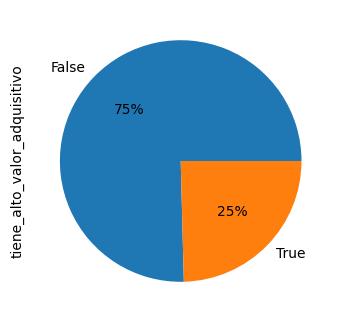

In [177]:
plt.figure(dpi=100)
df_palermo = df[df['barrio'] == "palermo"]
df_palermo['tiene_alto_valor_adquisitivo'].value_counts().plot(
    kind='pie', autopct='%1.0f%%'
)

Considerando que la mayor parte de la gente entrevistada es del barrio *Palermo*, esta información no nos aporta demasiado debido a que las proporciones son similares a la variable que queremos estimar.

Por lo que concluimos que:
*   **El barrio no sería relevante a la hora de estimar si una persona tiene o no alto valor adquisitivo.**


## ¿El estado marital nos podrá decir algo?

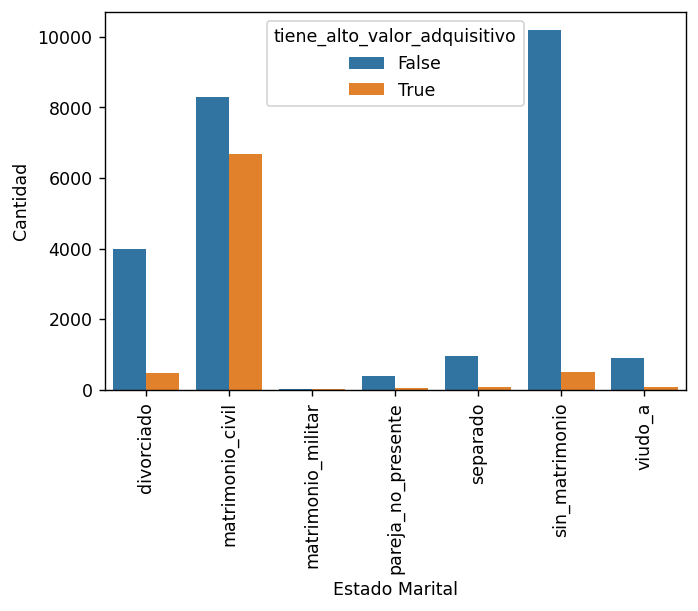

In [178]:
plt.figure(dpi=125)
ax = sns.countplot(x='estado_marital',data=df,hue='tiene_alto_valor_adquisitivo')
ax.set_ylabel("Cantidad")
ax.set_xlabel("Estado Marital")
plt.xticks(rotation=90)
plt.show()

Del siguiente grafico vemos que si el estado marital de la persona entrevistada no es *matrimonio_civil*, la probabilidad de que no tenga alto valor adquisitivo son mayores. Veamos cuanta gente cumple con esta condición:

In [179]:
total = len(df)
cantidad_sin_matromonio_civil = len(df[df['estado_marital'] != "matrimonio_civil"])
porcentaje = (cantidad_sin_matromonio_civil / total) * 100
print("Unas",cantidad_sin_matromonio_civil,"no estan casadas. Esto representa un",porcentaje,"del total entrevistados.")

Unas 17585 no estan casadas. Esto representa un 54.00632658702128 del total entrevistados.


Estos valores son muy relevantes devido a que parte la muestra a la mitad con altas probabilidades de afirmar que la persona no tendrá alto valor adquisitivo:

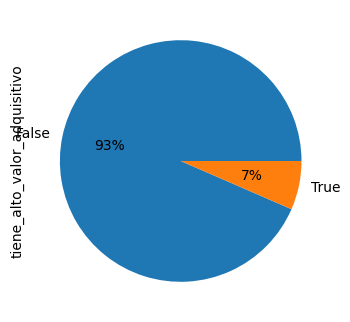

In [180]:
plt.figure(dpi=100)
df_sin_matrimonio_civil = df[df['estado_marital'] != "matrimonio_civil"]
df_sin_matrimonio_civil['tiene_alto_valor_adquisitivo'].value_counts().plot(
    kind='pie', autopct='%1.0f%%'
)
plt.show()

Concluimos que: 
 - **Si el estado marital de la persona no es *matrimonio_civil*, estamos un 93% seguros que NO tendrá valor adquisitivo.**
 
 (Esta conclusión resulta ser la mas fuerte y es la que usaremos inicialmente para predecir la variable objetivo)

## ¿Y que pasa con la edad de la persona?

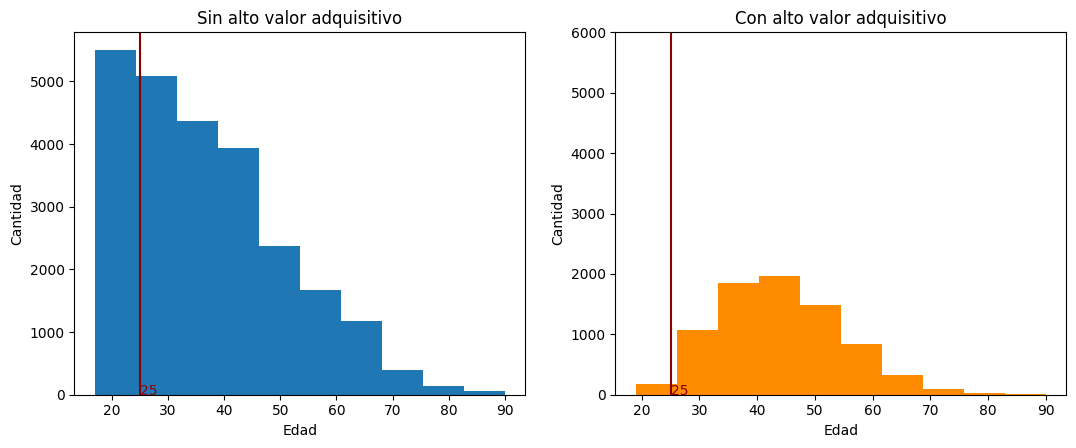

In [181]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_nva = df[df.tiene_alto_valor_adquisitivo == False]
df_va = df[df.tiene_alto_valor_adquisitivo == True]
x = 25

df_nva.edad.plot(kind='hist', ax=axes[0])
axes[0].set_title("Sin alto valor adquisitivo")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Edad")
axes[0].axvline(x, color="darkred")
axes[0].text(x, .5, '25', color="darkred")

df_va.edad.plot(kind='hist',color='darkorange', ax=axes[1])
axes[1].set_title("Con alto valor adquisitivo")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Edad")
axes[1].axvline(x, color="darkred")
axes[1].text(x, .5, '25', color="darkred")

plt.ylim([0, 6000])
plt.show()

Vemos que a partir de los graficos podemos identificar que aquellas personas menores a 25 años no tiene alto valor adquisitivo.

## ¿Aquellas personas que tienen mayor horas trabajadas registradas tienden a tener valor adquisitivo?

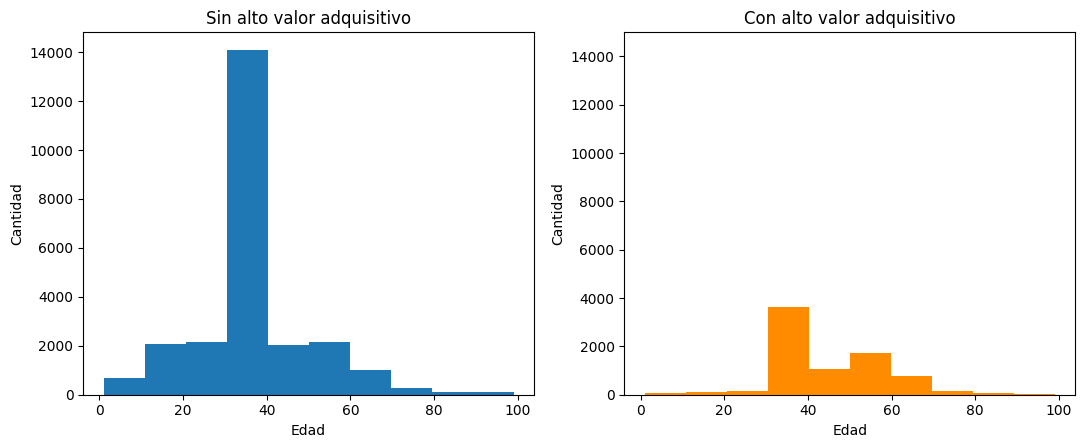

In [182]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_nva = df[df.tiene_alto_valor_adquisitivo == False]
df_va = df[df.tiene_alto_valor_adquisitivo == True]

df_nva.horas_trabajo_registradas.plot(kind='hist', ax=axes[0])
axes[0].set_title("Sin alto valor adquisitivo")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Edad")

df_va.horas_trabajo_registradas.plot(kind='hist',color='darkorange', ax=axes[1])
axes[1].set_title("Con alto valor adquisitivo")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Edad")

plt.ylim([0, 15000])
plt.show()

No podemos sacar una conclusión a simple vista debido a que las distribuciones de ambos graficos son similares pero con distintas cantidades.

# Relaciones

Una vez analizado las distintas columnas con nuestra variable objetivo (ver si una persona tiene o no alto valor adquisitivo) llegamos a las distintas conclusiones que se muestran a continuación:

*   El estado marital de la persona es muy relevante en el valor adquisitivo. Si el mismo no es *matrimonio_civil*, es mas propensa a no tener alto valor adquisitivo
*   Si la persona es mujer, es mas propensa a no tener alto valor adquisitivo
*   Si la persona tiene balance neutro, es mas propensa a no tener alto valor adquisitivo
*   Si la persona tiene un balance muy positivo, es mas propensa a  tener alto valor adquisitivo
*   Si la persona estudió menos de 12 años, es mas propensa a no tener alto valor adquisitivo
*   Si la perosna sigue el judaismo, es mas propensa a no tener alto valor adquisitivo
*   Si la persona es menor de 25 años, es mas propensa a no tener alto valor adquisitivo
*   Por ultimo, el barrio no nos dice si la persona tiene o no alto valor adquisitivo


Procederemos a elejir la que consideramos que divida mas a la muestra. En nuestro caso decidimos que el **estado marital** de la persona divide considerablemente si no es **matrimonio_civil**.

Inicialmente sabemos que si el estado marital de la persona es *matrimonio_civil* podemos decir que no tendrá alto valor adquisitivo, pero que pasa en el otro caso?. Comenzaremos estudiando este caso

In [183]:
df_mc = df[df['estado_marital'] == "matrimonio_civil"]

Veamos cuantos son los que tienen alto valor adquisitivo:

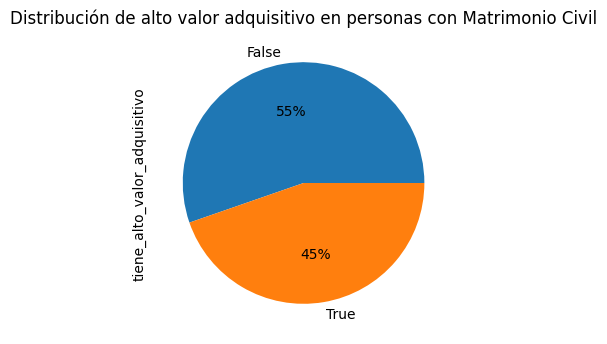

In [184]:
plt.figure(dpi=100)
df_mc['tiene_alto_valor_adquisitivo'].value_counts().plot(
    kind='pie', autopct='%1.0f%%'
)
plt.title("Distribución de alto valor adquisitivo en personas con Matrimonio Civil")

La división resulta equitativa para ambas partes, por lo que intentaremos buscar alguna otra columna que separe considerablemente para poder llegar a una nueva conclusión.

## Matrimonio civil vs Balance

Veamos si existe alguna relación entre el matrimonio civil y el balance de la persona (recordemos que el balance puede ser: Negativo, Neutro, Positivo o Muy Positivo):

Text(0, 0.5, 'Cantidad')

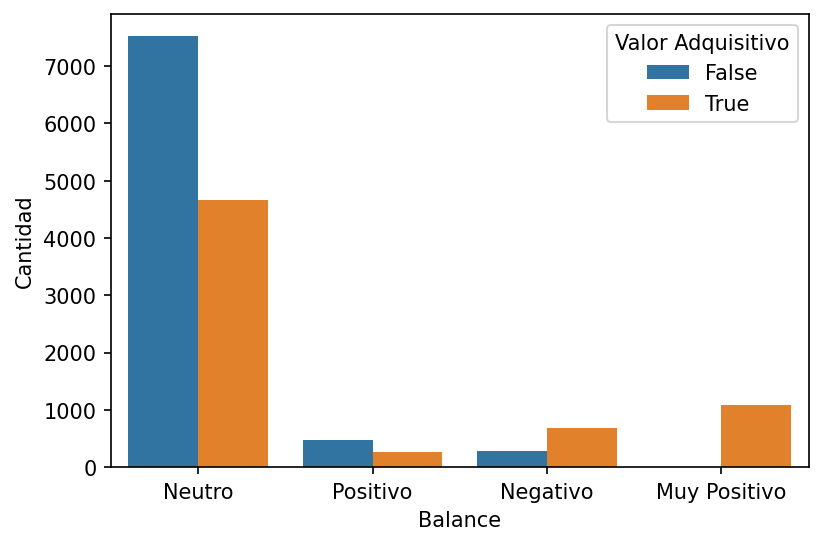

In [185]:
plt.figure(dpi=150)
ax = sns.countplot(x='balance',data=df_mc,hue='tiene_alto_valor_adquisitivo')
ax.legend(title='Valor Adquisitivo', loc='upper right')
ax.set_xlabel("Balance")
ax.set_ylabel("Cantidad")

De este ultimo grafico vemos que si la persona tiene un balance *Muy Positivo* podremos asegurar que tendrá alto valor adquistivo. Pero la cantidad de casos que cumplen esta ultima condición es muy poca para generar una división considerable. Mostremos esto ultimo para asegurarnos:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


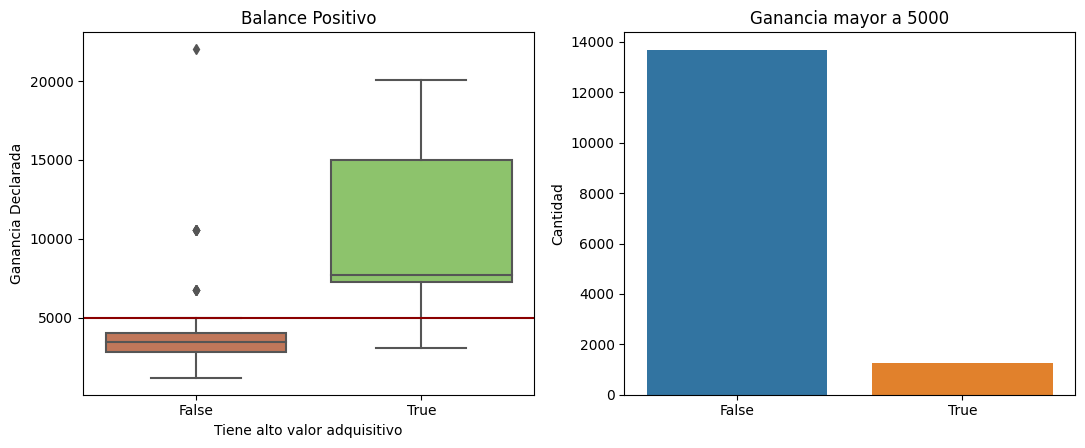

In [206]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_aux = df_mc[(df_mc["ganancia_perdida_declarada_bolsa_argentina"] > 0) & (df_mc["ganancia_perdida_declarada_bolsa_argentina"] < 25000)]
ax0 = sns.boxplot(
    data=df_aux,
    y='ganancia_perdida_declarada_bolsa_argentina',
    x='tiene_alto_valor_adquisitivo',
    palette=['#D17049', "#89D15E"],
    ax=axes[0]
)
ax0.set_title("Balance Positivo")
ax0.set_xlabel("Tiene alto valor adquisitivo")
ax0.set_ylabel("Ganancia Declarada")
ax0.axhline(y=5000, color="darkred")

df_mc['muy_positivo'] = df_mc['ganancia_perdida_declarada_bolsa_argentina'] > 5000
ax1 = sns.countplot(x='muy_positivo',data=df_mc,ax=axes[1])
ax1.set_title("Ganancia mayor a 5000")
ax1.set_xlabel("")
ax1.set_ylabel("Cantidad")

plt.show()

## Matrimonio civil vs Años estudiados



Veamos como se relacionan con los años estudiados:

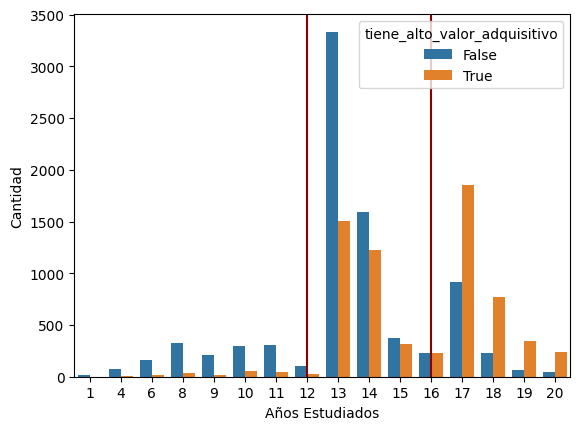

In [187]:
plt.figure(figsize=(6.4, 4.8),dpi=100)
ax = sns.countplot(x='anios_estudiados',data=df_mc,hue='tiene_alto_valor_adquisitivo')
ax.set_ylabel("Cantidad")
ax.set_xlabel("Años Estudiados")
plt.axvline(x=7, color="darkred")
plt.axvline(x=11, color="darkred")

Observamos que es similar a la distribución de los años estudiados general. Nuevamente tenemos dos zonas escenciales:

-   Aquellos con mas de 16 años estudiados tienden a tener alto valor adquisitivo
-   Aquellos con menos de 13 años estudiados tienden a no tener alto valor adquisitivo

Veamos para cada zona cuanto divide a la muestra y si es considerable para llegar a una conclusión:



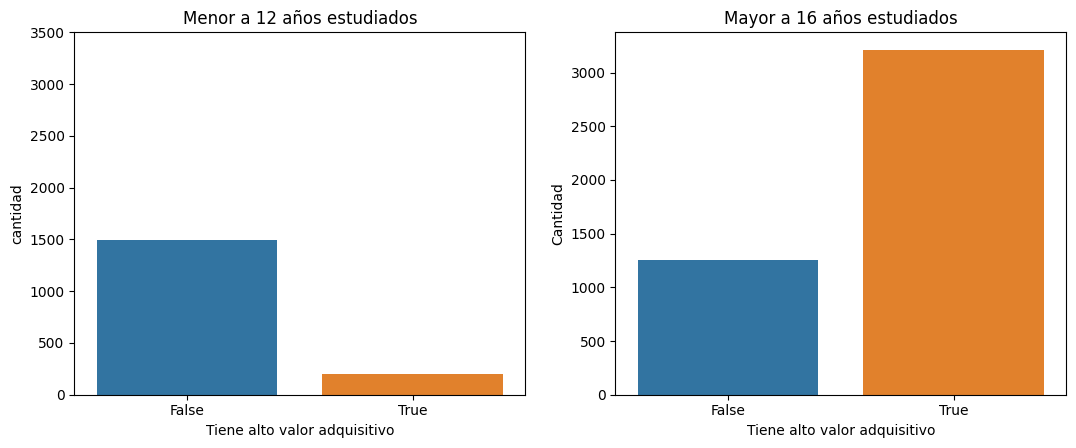

In [210]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_mc_sec = df_mc[df_mc['anios_estudiados'] <= 12]
df_mc_uni = df_mc[df_mc['anios_estudiados'] > 16]

ax0 = sns.countplot(x='tiene_alto_valor_adquisitivo',data=df_mc_sec,ax=axes[0])
ax0.set_title("Menor a 12 años estudiados")
ax0.set_ylabel("cantidad")
ax0.set_xlabel("Tiene alto valor adquisitivo")
ax0.set_ylim([0, 3500])

ax1 = sns.countplot(x='tiene_alto_valor_adquisitivo',data=df_mc_uni,ax=axes[1])
ax1.set_title("Mayor a 16 años estudiados")
ax1.set_ylabel("Cantidad")
ax1.set_xlabel("Tiene alto valor adquisitivo")


plt.show()

Vemos que para aquellos con menos de 12 años estudiados la división resulta más exacta, pero la cantidad de casos es mayor para aquellos con mas de 16 años estudiados. Entonces debemos tomar una decisión en cual elegir y que consideremos que será relevante para la predicción de la variable objetivo. Optamos por quedarnos con la primera opción:

*    Aquellos con mas de 16 años estudiados tienden a tener alto valor adquisitivo

(Esta conclusión resulta ser mas fuerte que la del balance puesto que hay mas casos)

Ahora debemos observar el otro caso, las personas que estan casadas civilmente pero no tienen mas de 16 años estudiados, y ver como podemos subdividirlas.

### Menos de 16 años estudiados

Como la mayoria de las personas que nos queda no tienen alto valor adquisitivo (esta será nuestra estimación final), debemos buscar alguna división fuerte que estime que la persona tendrá alto valor adquisitivo.

Provemos nuevamente con el balance:

Text(0, 0.5, 'Cantidad')

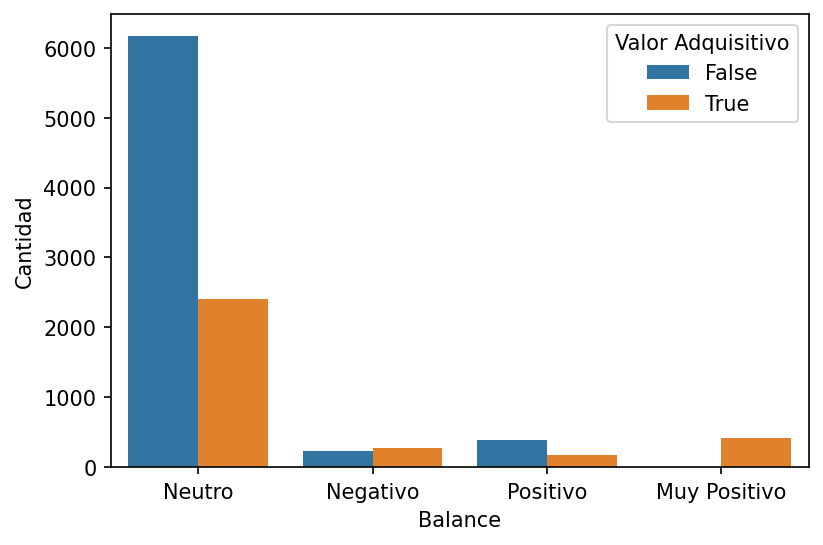

In [217]:
df_mc_16 = df_mc[df_mc['anios_estudiados'] < 16]

plt.figure(dpi=150)
ax = sns.countplot(x='balance',data=df_mc_16,hue='tiene_alto_valor_adquisitivo')
ax.legend(title='Valor Adquisitivo', loc='upper right')
ax.set_xlabel("Balance")
ax.set_ylabel("Cantidad")

Nuevamente, aquellas personas con balance *Muy positivo* tienen alto valor adquisitivo. Buscemos algun valor aproximado para determinar esta condición y asi finalizar:

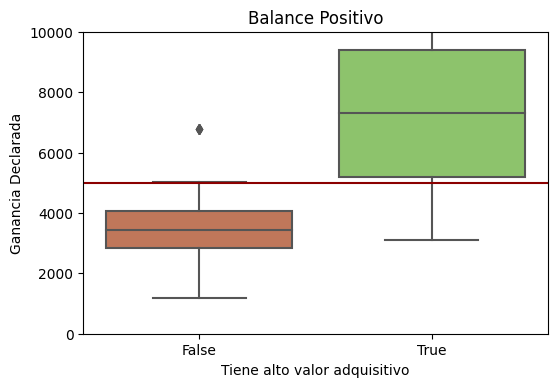

In [232]:
plt.figure(dpi=100)
df_aux = df_mc_16[(df_mc_16["ganancia_perdida_declarada_bolsa_argentina"] > 0)]
ax0 = sns.boxplot(
    data=df_aux,
    y='ganancia_perdida_declarada_bolsa_argentina',
    x='tiene_alto_valor_adquisitivo',
    palette=['#D17049', "#89D15E"]
)
ax0.set_ylim([0,10000])
ax0.set_title("Balance Positivo")
ax0.set_xlabel("Tiene alto valor adquisitivo")
ax0.set_ylabel("Ganancia Declarada")
ax0.axhline(y=5000,color="darkred")


La ganancia igual a **5000** muestra ser el valor adecuado para dividir la muestra. Entonces:


*  **Aquellas personas con ganancia igual o mayor a 5000 tendrán alto valor adquistivo**

Como dijimos al principio de esta sección, las personas que nos restan estimaremos que no tendrán alto valora adquisitivo. Veamos que tan buena resulta esta estimación:

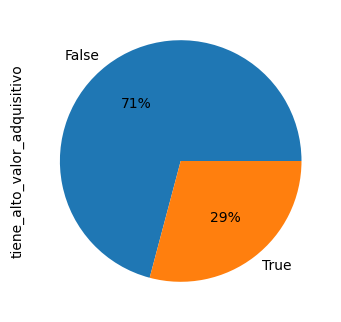

In [234]:
plt.figure(dpi=100)
df_aux = df_mc_16[df_mc_16.ganancia_perdida_declarada_bolsa_argentina < 5000]
df_aux['tiene_alto_valor_adquisitivo'].value_counts().plot(
    kind='pie', autopct='%1.0f%%'
)

# Conclusión

Mediante nuestro analisis exploratorio de los datos hemos pudido entender cada uno de los datos y  cómo se relacionan entre sí para saber cuáles son los factores más importantes que determinan si un usuario tiene altos o bajos ingresos. 

Adicionalmente obtuvimos las siguientes conclusiones acerca del analisis:

*   El estado marital es muy relevante en el valor adquisitivo ya que si el estado marital de la persona no es *matrimonio_civil* es mas propenso a no tener alto valor adquisitivo
*   Aquellas personas con *matrimonio_civil* y mas de 16 años estudiados son más propensos a tener alto valor adquisitivo
*   Aquellas personas con un balance muy positivo son mas propensos a tener alto valor adquisitivo
*   El barrio no nos dice mucho acerca de los ingresos de la persona



# Baseline

En base a nuestro analisis exploratorio de los datos y a las conclusiones mencionadas realizaremos un breve baseline que estime si una persona tendrá o no alto valor adquisitivo:

In [215]:
def baseline(df: pd.DataFrame):

  for index, sample in df.iterrows():
    if(sample['estado_marital'] != "matrimonio_civil"):
          df.at[index,'tiene_alto_valor_adquisitivo_estimado'] = False
    else:
      if(sample['anios_estudiados'] > 16):
        df.at[index,'tiene_alto_valor_adquisitivo_estimado'] = True
      else:
        if(sample['ganancia_perdida_declarada_bolsa_argentina'] >= 5000):
          df.at[index,'tiene_alto_valor_adquisitivo_estimado'] = True
        else:
          df.at[index,'tiene_alto_valor_adquisitivo_estimado'] = False


  resultado = df['tiene_alto_valor_adquisitivo_estimado'].values.tolist()
  del(df['tiene_alto_valor_adquisitivo_estimado'])
  return resultado

accuracy = accuracy_score(df.tiene_alto_valor_adquisitivo, baseline(df)).round(4)
print("La predicción tuvo un",accuracy * 100,"% de precisión")

La predicción tuvo un 83.34 % de precisión


# MORE TRASH

In [197]:
import graphviz
import ipywidgets as widgets
from IPython.display import SVG, display
from ipywidgets import Button, IntSlider, interactive
from sklearn import preprocessing, tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier

In [198]:
def feature_engineering(data):
    """Hace las transformaciones de datos necesarias."""
    data = pd.get_dummies(data, drop_first=True, columns=['barrio', 'estado_marital', 'genero','religion','rol_familiar_registrado'])

    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(data.tiene_alto_valor_adquisitivo)

    X = data.drop(columns=['tiene_alto_valor_adquisitivo'])
    y = label_encoder.transform(data.tiene_alto_valor_adquisitivo)

    return X, y, data, label_encoder

In [199]:
def get_tree(X, y, max_depth=5, min_samples_leaf=10):
    """Devuelve un árbol entrenado."""
    clf = tree.DecisionTreeClassifier(
        random_state=117, max_depth=max_depth, min_samples_leaf=min_samples_leaf
    )
    clf.fit(X, y)
    return clf


def plot_tree(max_depth, min_samples_leaf):
    """Interfaz interactiva para visualizar un árbol entrenado."""

    df_nuevo = df.copy()
    del(df_nuevo['balance'])
    del(df_nuevo['categoria_de_trabajo'])
    del(df_nuevo['trabajo'])

    X, y, df_nuevo, y_encoder = feature_engineering(df_nuevo)
    clf = get_tree(X, y, max_depth, min_samples_leaf)

    dot_data = tree.export_graphviz(
        clf,
        out_file=None,
        feature_names=X.columns,
        class_names=str(y_encoder.classes_),
        filled=True,
        rounded=True,
        special_characters=True,
    )
    graph = graphviz.Source(dot_data)
    display(SVG(graph.pipe(format='svg')))


inter = interactive(
    plot_tree,
    max_depth=IntSlider(min=1, max=15),
    min_samples_leaf=IntSlider(min=1, max=3000, value=10),
)
display(inter)

interactive(children=(IntSlider(value=1, description='max_depth', max=15, min=1), IntSlider(value=10, descript…

## Sección nueva

In [200]:
#Suponiamos que los valores NAN en columna categoria_de_trabajo se superponian con los valores NAN en columna trabajo
#y efectivamente era asi
df[df['trabajo'].isna() & df['categoria_de_trabajo'].isna()]

,anios_estudiados,barrio,categoria_de_trabajo,edad,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo,balance
27,14,boedo,NaN,54,matrimonio_civil,0,hombre,60,budismo,casado_a,True,NaN,Neutro
61,8,otro,NaN,32,pareja_no_presente,0,hombre,40,cristianismo,sin_familia,False,NaN,Neutro
69,14,palermo,NaN,25,sin_matrimonio,0,hombre,40,cristianismo,con_hijos,False,NaN,Neutro
77,10,palermo,NaN,67,matrimonio_civil,0,hombre,2,cristianismo,casado_a,False,NaN,Neutro
106,10,palermo,NaN,17,sin_matrimonio,34095,mujer,32,cristianismo,con_hijos,False,NaN,Muy Positivo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32530,17,palermo,NaN,35,matrimonio_civil,0,mujer,55,cristianismo,casado_a,True,NaN,Neutro
32531,17,palermo,NaN,30,sin_matrimonio,0,mujer,99,budismo,sin_familia,False,NaN,Neutro
32539,20,palermo,NaN,71,matrimonio_civil,0,hombre,10,cristianismo,casado_a,True,NaN,Neutro
32541,13,palermo,NaN,41,separado,0,mujer,32,judaismo,sin_familia,False,NaN,Neutro


## Impurezas

In [202]:
#Me quedo solo con las columnas categoricas para calcular el gini
df_gini = df.drop(columns=['edad','anios_estudiados','horas_trabajo_registradas','ganancia_perdida_declarada_bolsa_argentina'])
df_gini.head()

,barrio,categoria_de_trabajo,estado_marital,genero,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo,balance
0,palermo,empleado_provincial,sin_matrimonio,hombre,cristianismo,sin_familia,False,entretenimiento,Positivo
1,palermo,monotributista,matrimonio_civil,hombre,cristianismo,casado_a,False,directivo_gerente,Neutro
2,palermo,relacion_de_dependencia,divorciado,hombre,cristianismo,sin_familia,False,limpiador,Neutro
3,palermo,relacion_de_dependencia,matrimonio_civil,hombre,judaismo,casado_a,False,limpiador,Neutro
4,balvanera,relacion_de_dependencia,matrimonio_civil,mujer,judaismo,casado_a,False,profesional_especializado,Neutro


In [203]:
def cant_adquisitivo(x):
    return (x == True).sum()
def cant_no_adquisitivo(x):
    return (x == False).sum()
def gini_leaf(x):
    return 1 - ((cant_adquisitivo(x)/x.count())**2 + (cant_no_adquisitivo(x)/x.count())**2 )
def gini(x):
    return (x.count()/len(df_gini)) * gini_leaf(x)

gini_initial = gini_leaf(df['tiene_alto_valor_adquisitivo']).round(4)
print("The initial gini of the dataset is:",gini_initial)

columns = df_gini.columns.to_list()
columns.remove('tiene_alto_valor_adquisitivo')

gini_results = []
gini_gain_results = []
for feature in columns:
  gini_value = df_gini[[feature,'tiene_alto_valor_adquisitivo']].groupby(feature).agg(
      ['count',cant_adquisitivo,cant_no_adquisitivo,gini_leaf,gini]
      )['tiene_alto_valor_adquisitivo']['gini'].sum().round(4)
  gini_gain_value = (gini_initial - gini_value).round(4)
  gini_results.append(gini_value)
  gini_gain_results.append(gini_gain_value)
  
result = {'gini': gini_results,'gini_gain': gini_gain_results}
df_result = pd.DataFrame(result, columns = ['gini','gini_gain'], index=columns)
df_result


The initial gini of the dataset is: 0.3656


,gini,gini_gain
barrio,0.3621,0.0035
categoria_de_trabajo,0.3434,0.0222
estado_marital,0.2925,0.0731
genero,0.3486,0.0170
religion,0.3619,0.0037
rol_familiar_registrado,0.2905,0.0751
trabajo,0.3098,0.0558
balance,0.3068,0.0588
